# Support Vector Machine Classifier

In [374]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

## Binary Classification

A binary classifier is a function for predicting a binary outcome $y = \pm 1$ based the values of $p$ features contained in a vector $x\in \mathbb{R}^p$.  A successful binary classifier will predict $y$ with high precision and high recall.

* **Precision**. The number of real positives divided by the number of predicted positives. A high precision test has a low false positive rate.

* **Recall**. The number of real positives divided by number of actual positives. A high recall test has a low false negative rate.

For example, consider an application that authenticates banknotes for a vending machine. A false positive would accept a counterfeit banknote, clearly an undesirable outcome for the seller. The seller would be interested in high precision. A buyer, however, may be frustrated if a valid banknote is needlessly rejected by the vending machine. The buyer would be interested in high recall.

The challenge of developing binary classifiers is to find features, and functions to evaluate those features, that provide the precision and recall needed for a particular application.

## Linear Support Vector Machines (SVM)

A linear support vector machine is a binary classifier that uses linear form to determine the classification. 

$$\hat{y} = \text{sgn}\ (\sum_{i=1}^p w_i x_i - v)$$

In effect, the linear function divides the feature space $\mathbb{R}^p$ with a hyperplane.

Given a training set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$, the computational task is to find coefficients $w_1, \dots, w_p$ and $b$ to achieve high precision and high recall for a validation set.

A point  $(x_i, y_i)$ in the validation set is successfully classified if the value

$$ y_i (\sum_{i=1}^p w_i x_i + b) > 0 $$

whereas the point is misclassified if 

$$ y_i (\sum_{i=1}^p w_i x_i + b) < 0 $$

Given parameters $w_i$ and $b$, the **hinge-loss** function is defined as

$$\ell(x, y) = \max\left[0, 1 - y(\sum_{i=1}^p w_i x_i + b)\right]$$

This loss function has several properties that make it useful fitting linear support vector machine.  For a misclassified point, the hinge-loss function grows in proportion to 

$$C_i = \sum_{i=1}^p w_i x_i + b$$

which we call the *scoring* function. The scoring function assigns a large loss to data far away from the separation plane.  For correctly points that are correctly classified the scoring function is reduced to a value no smaller than zero. A soft penalty is assigned to points that correctly classified but still near the separating hyperplane. 

A common feature of fitting a linear SVM is to assign a regularization term

$$\min \frac{1}{n}\sum \max\left[0, 1 - y_i(\sum_{i=1}^n w_i x_i + b)\right] + \lambda \|w\|$$



## Data Set 

The following data set contains data from a collection genuine and counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images and a binary variable where 0 indicates genuine and 1 indicates counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [375]:
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

df = pd.read_csv("data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

df_train = df_train.reset_index()
X_train = df_train[["variance", "skewness", "curtosis", "entropy"]]
y_train = 2*df_train["class"] - 1

df_test = df_test.reset_index()
X_test = df_test[["variance", "skewness", "curtosis", "entropy"]]
y_test = 2*df_test["class"] - 1

center = X_train.mean()
scale = X_train.std()

# center and scale with training d
X_train = (X_train - center) / scale
X_test = (X_test - center) / scale

## Dimensionality Reduction with PCA

To provide an effective visualization, for a first attempt an SVM classifer we  will reduce the four observed features to the two dominant components returned by [principal component analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA). 

* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

### Linear PCA

     variance  skewness  curtosis   entropy
PC0 -0.263669 -0.637439  0.610493  0.389163
PC1 -0.747413  0.066620  0.156190 -0.642293
PC2  0.606700 -0.118227  0.516395 -0.592683
PC3 -0.061377  0.758456  0.579861  0.291099


<BarContainer object of 4 artists>

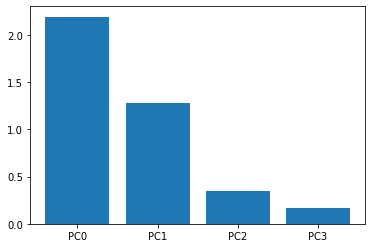

In [376]:
n, p = X_train.shape

pca = PCA(n_components=p).fit(X_train)

# format PCA loadings and varianace ratios
loadings = pd.DataFrame(pca.components_, index=[f"PC{_:d}" for _ in range(p)])
loadings.columns = X_train.columns
print(loadings)
plt.bar(["PC0", "PC1", "PC2", "PC3"], pca.explained_variance_)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

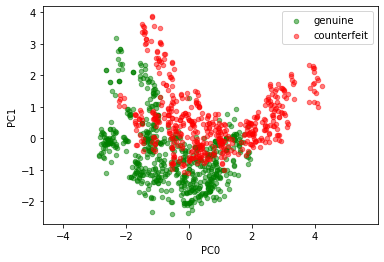

In [377]:
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(pca.fit(X_train).transform(X_train), columns=["PC0", "PC1"])

def Xy_plot(X, y):
    fig, ax = plt.subplots()
    X[y==-1].plot(x=0, y=1, kind="scatter", ax=ax, c='g', alpha=0.5, label="genuine")
    X[y== 1].plot(x=0, y=1, kind="scatter", ax=ax, c='r', alpha=0.5, label="counterfeit")
    ax.axis('equal')
    return ax

Xy_plot(X_train_pca, y_train)

### Kernel PCA

The first two principal components of linear PCA provides some, but not complete, discrimination between the two classes of banknotes. This motivates a look at kernel PCA. After several trials with different kernels and settings, a radial basis function kernel appears to separate the two classes of banknotes using the first two components.

<AxesSubplot:xlabel='KPC0', ylabel='KPC1'>

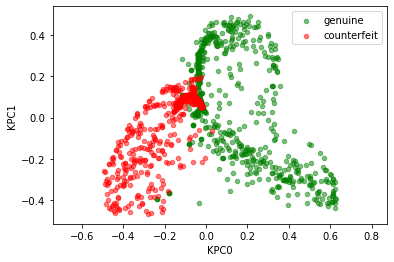

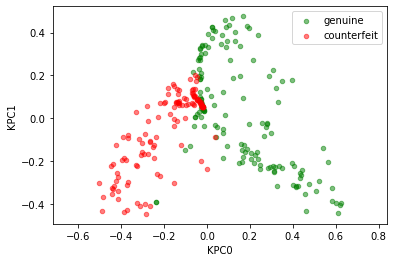

In [378]:
def kpca_transform(X, X_train=X_train):
    kpca = KernelPCA(n_components=2, kernel="rbf", gamma=1.5).fit(X_train)
    X_kpca = pd.DataFrame(kpca.transform(X))
    X_kpca.columns = ["KPC0", "KPC1"]
    return X_kpca
    
Xy_plot(kpca_transform(X_train), y_train)
Xy_plot(kpca_transform(X_test), y_test)

## Fit SVM to the features

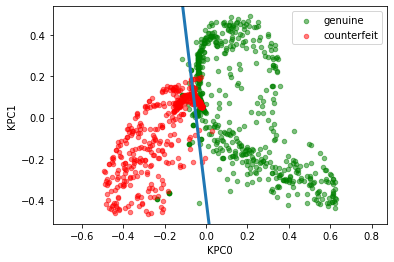

In [379]:
def svm_fit(X, y, alpha=0):
    X = X.to_numpy()
    n, p = X.shape
    y = np.reshape(y.to_numpy(), (n, 1))
    w = cp.Variable((p, 1))
    b = cp.Variable()
    hinge_loss = cp.sum(cp.pos(1 - cp.multiply(y, X @ w + b)))
    problem = cp.Problem(cp.Minimize(hinge_loss/n + alpha*cp.norm(w, 1)))
    problem.solve()
    return w.value, b.value

def svm_plot(w, b, ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.plot([xmin, xmax], [-(w[0]*xmin + b)/w[1], -(w[0]*xmax + b)/w[1]], lw=3)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

# train svm on kpca of X_train
w, b = svm_fit(kpca_transform(X_train), y_train)

# plot kpca of X_train and svm
ax = Xy_plot(kpca_transform(X_train), y_train)
svm_plot(w, b, ax)

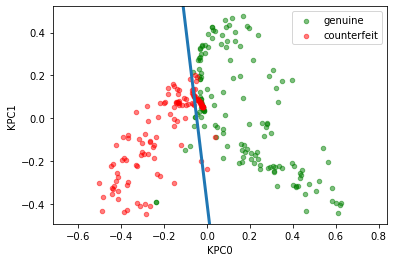

In [380]:
# train
w, b = svm_fit(kpca_transform(X_train), y_train)

# compare to test data
ax = Xy_plot(kpca_transform(X_test), y_test)
svm_plot(w, b, ax)

### Test SVM classifier

In [381]:
def svm_pred(w, b, X):
    return np.sign(X @ w + b)[0]

# train svm
w, b = svm_fit(kpca_transform(X_train), y_train)

# predict
y_pred = svm_pred(w, b, kpca_transform(X_test))

def compare(y_test, y_pred):
    tp = sum((y_test == 1) * (y_pred == 1))
    tn = sum((y_test == -1) & (y_pred == -1))
    fp = sum((y_test == -1) * (y_pred == 1))
    fn = sum((y_test == 1) * (y_pred == -1))
    print(f" true positives = {tp}")
    print(f"false positives = {fp}")
    print(f" true negatives = {tn}")
    print(f"false negatives = {fn}") 
    print(f"      precision = {tp/(tp + fp):5.3f}")
    print(f"         recall = {tp/(tp + fn):5.3f}")
    

compare(y_test, y_pred)

 true positives = 92
false positives = 7
 true negatives = 139
false negatives = 37
      precision = 0.929
         recall = 0.713


## Full featured SVM

In [382]:
# train
w, b = svm_fit(X_train, y_train)

# compare to test data
y_pred = svm_pred(w, b, X_test)

compare(y_test, y_pred)

 true positives = 127
false positives = 1
 true negatives = 145
false negatives = 2
      precision = 0.992
         recall = 0.984


## Pyomo Implementation

In [383]:
import pyomo.environ as pyo

def pyomo_svm_fit(X, y, alpha=0):
    
    n, p = X.shape
    
    m = pyo.ConcreteModel()
    
    m.n = pyo.RangeSet(0, n-1)
    m.p = pyo.RangeSet(0, p-1)
    
    m.w = pyo.Var(m.p)
    m.b = pyo.Var()
    m.hpos = pyo.Var(m.n, domain=pyo.NonNegativeReals)
    m.hneg = pyo.Var(m.n, domain=pyo.NonNegativeReals)
    m.wpos = pyo.Var(m.p, domain=pyo.NonNegativeReals)
    m.wneg = pyo.Var(m.p, domain=pyo.NonNegativeReals)
    
    @m.Constraint(m.n)
    def hinge_loss(m, n):
        return m.hpos[n] - m.hneg[n] == 1 - y[n]*(sum(m.w[p]*X.iloc[n,p] for p in m.p) + m.b)
    
    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(m.hpos[n] for n in m.n)/n + alpha * sum(m.wpos[p] + m.wneg[p] for p in m.p)
    
    pyo.SolverFactory('glpk').solve(m)
    
    w = np.array([m.w[p]() for p in m.p])
    b = m.b()
    
    return w, b
    
pyomo_svm_fit(X_train, y_train)


(array([-10.88658229, -12.00148247, -10.8958858 ,  -0.57211715]),
 -5.72817198239605)

In [373]:
print(svm_fit(X_train, y_train))
print(pyomo_svm_fit(X_train, y_train))

(array([[-10.75286401],
       [-12.41829058],
       [-11.22256195],
       [ -0.78050655]]), array(-5.61276163))
(array([-10.75286401, -12.41829058, -11.22256196,  -0.78050655]), -5.61276162942887)
